In [114]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
erf = np.vectorize(math.erf)
from b_spline import B_spline
from scipy.stats import multivariate_normal

def bake_cake(orientation, angle, resolution=(256,256), freq_min=.25, freq_max=.5, cake_type='basic', mean=[.0, .5], std=[[.005,0.0],[0.0,.0025]]):
    '''
        Generate cake wavelet mask
    '''
    
    X,Y = create_mesh(resolution)

    radial_coord, angular_coord = transform_cartesian_to_radial(X,Y)
    
    assert radial_coord.shape == angular_coord.shape
    assert np.alltrue(angular_coord>0)

    if cake_type == 'basic':
        values = basic_cake(radial_coord, angular_coord, orientation, angle, freq_max)
    elif cake_type == 'b_spline':
        values = b_spline_cake(radial_coord, angular_coord, orientation, angle, freq_max)
    elif cake_type == 'basic_bp':
        values = basic_bandpass(radial_coord, angular_coord, orientation, angle, freq_min, freq_max)
    elif cake_type == 'gabor':
        values = gabor(X, Y, orientation, np.array(mean), np.array(std))

    X,Y = transform_radial_to_cartesian(radial_coord, angular_coord)
    return np.stack([X, Y, values])

def create_mesh(resolution):
    '''
        Create a coordinate grid
    '''
    x_dim, y_dim = resolution
    
    X = np.linspace(-1, 1, x_dim)
    X = X[:, None].repeat(y_dim, axis=1)

    Y = np.linspace(-1, 1, y_dim)
    Y = Y[None, :].repeat(X.shape[0], axis=0)
    return X, Y

def b_spline_cake(  radial_coord, angular_coord, orientation, angle, freq_max, 
                    b_n = B_spline(4), radial_boundary_strength=2):
    '''
        Creates soft-boundary cake wavelet filters
    '''
    # angular resolution
    # equivalent to 2pi/N_slices
    s = angle

    # Shift center of spline to orientation
    shifted = (angular_coord-orientation)%(2*np.pi) - np.pi

    # Use erfc to create a soft radial boundary
    radial_boundary = (1-erf(radial_boundary_strength*(radial_coord-freq_max)))
    values = b_n(shifted/s) * radial_boundary
    
    return values

def basic_bandpass(radial_coord, angular_coord, orientation, angle, freq_min, freq_max):
    '''
        Create cake wavelets with hard boundaries
    '''
    values = np.zeros(angular_coord.shape)
    start = (orientation - angle/2) % (2*np.pi)
    end = (orientation + angle/2) % (2*np.pi)
    radial_idx = np.logical_and(freq_min<radial_coord, radial_coord<freq_max)
    if start>=end:
        # Catch if the angle overflows and loops around
        angle_idx = np.logical_or(start < angular_coord, angular_coord < end)
        
        idx = np.logical_and(angle_idx, radial_idx)
        values[idx] = 1
    else:
        # Between start and last
        angle_idx = np.logical_and(start < angular_coord, angular_coord < end)
        idx = np.logical_and(angle_idx,radial_idx)
        values[idx] = 1
    return values
def rotation_matrix(angle):
    '''
        Input:
            Angle - Rotation angle in Radians
        Output:
            mat - 2x2 Rotation matrix
    '''
    c = np.cos(angle)
    s = np.sin(angle)
    mat = np.array([[c , s],
                     [-s, c]])
    return mat

def gabor(X, Y, orientation, mean, cov):
    '''
        Create cake wavelets with hard boundaries
    '''
    values = np.zeros(X.shape)
    rot = rotation_matrix(orientation)
    mean = rot@mean
    # ?
    cov = rot @ cov @ rot.T
    coord = np.stack([X,Y], axis=-1)
    values = multivariate_normal(mean, cov).pdf(coord)
    return values

def basic_cake(radial_coord, angular_coord, orientation, angle, freq_max):
    '''
        Create cake wavelets with hard boundaries
    '''
    values = np.zeros(angular_coord.shape)
    start = (orientation - angle/2) % (2*np.pi)
    end = (orientation + angle/2) % (2*np.pi)
    if start>=end:
        # Catch if the angle overflows and loops around
        angle_idx = np.logical_or(start < angular_coord, angular_coord < end)
        radial_idx = radial_coord<freq_max
        idx = np.logical_and(angle_idx, radial_idx)
        values[idx] = 1
    else:
        # Between start and last
        angle_idx = np.logical_and(start < angular_coord, angular_coord < end)
        radial_idx = radial_coord<freq_max
        idx = np.logical_and(angle_idx,radial_idx)
        values[idx] = 1
    return values

def calculate_boundaries(max_radius, slices, radius_ticks):
    '''
        Calculates the orientation points for visualization
    '''
    radial_coord = np.arange(0, max_radius, radius_ticks)
    radial_coord = radial_coord[:, None].repeat(slices, axis=1)

    angular_coord = np.linspace(0, 360, slices, endpoint=False)
    angular_coord = angular_coord[:, None].repeat(radial_coord.shape[0], axis=1).T

    assert radial_coord.shape == angular_coord.shape

    values = np.ones(angular_coord.shape)

    X,Y = transform_radial_to_cartesian(radial_coord, angular_coord, degrees=True)
    
    return np.stack([X, Y])

def transform_cartesian_to_radial(X, Y):
    '''
        Convert to polar coordinates
        Input:
            X : x-domain discretized into N bins repeated M times (N x M)
            Y : y-domain discretized into M bins repeated N times (N x M)
        Return:
            r : The corresponding radial coordinate
            theta : The corresponding angular coordinate
    '''
    r = np.sqrt(X**2 + Y**2)
    ang = np.arctan2(X,Y) + np.pi
    return r, ang

def transform_radial_to_cartesian(rad, ang, degrees=False):
    '''
        Convert to Cartesian coordinates
        Input:
            r : The corresponding radial coordinate
            theta : The corresponding angular coordinate
        Return:
            X : x coordinate
            Y : y coordinate
    '''
    ang = ang
    if degrees==True:
        ang = np.deg2rad(ang)
    X = rad*np.cos(ang)
    Y = rad*np.sin(ang)
    return X, Y

def create_filter_bank(N_slices : int, resolution : tuple, wavelet_type : str):
    '''
        Input:
            N_slices : 2pi/angle. Denoted as S.
            resolution : Shape of image (N, M)
        Output:
            filters : 1 x 1 x S x N x M Tensor for elementwise product with batch
    '''
    angle = 2*np.pi/N_slices
    angles = np.linspace(0, 2*np.pi, N_slices, endpoint=False)
    filters = []
    # Create a filter for every orientation of a slice
    # This is equivalent to rotating the image and applying it to the image
    for orientation in angles:
        X, Y, val = bake_cake(orientation, angle, cake_type=wavelet_type, resolution=resolution)
        # Transform to match fft convensions
        val = transform_for_ifft(val)
        filters += [torch.tensor(val)]
    filters = torch.stack(filters).unsqueeze(0).unsqueeze(0)
    return filters

def transform_for_ifft(img):
    '''
        ifft expects positive frequencies 0:N followed by negative frequencies 0:N
    '''
    shape = img.shape
    N, M = shape
    img_2 = np.zeros(shape)
    pp_freqs = img[N//2:, M//2:]
    pn_freqs = img[N//2:, :M//2]
    np_freqs = img[:N//2, M//2:]
    nn_freqs = img[:N//2, :M//2]
    
    img_2 = np.zeros(shape)
    img_2[:N//2, :M//2] = pp_freqs
    img_2[:N//2, M//2:] = pn_freqs
    img_2[N//2:, :M//2] = np_freqs
    img_2[N//2:, M//2:] = nn_freqs
    return img_2

In [115]:
import PIL.Image as Image
class WaveletLiftingLayer(torch.nn.Module):
    def __init__(self, slices, resolution, wavelet_type='b_spline') -> None:
        super().__init__()
        # 1 x 1 x S x N x M
        self.register_buffer('filters', create_filter_bank(slices, resolution, wavelet_type))
        self._wavelet_type = wavelet_type
        
    def forward(self, x):
        '''
            Input:
                x - B x C x N x M Tensor
            Return
                y - B x C x S x N x M Tensor of 
        '''
        x_ = torch.fft.fft2(x)        
        x_ = x_.unsqueeze(-3) # B x C x 1 x N x M
        x_ = x_ * self.filters # B x C x S x N x M
        y = torch.fft.ifft2(x_)
        return y
        
print(torch.__version__)


x = Image.open('./erik.jpg')
x = torch.tensor(np.array(x))
N, M, C = x.shape
basic_layer = WaveletLiftingLayer(20, (N, M), wavelet_type='basic')
gabor_layer = WaveletLiftingLayer(20, (N, M), wavelet_type='gabor')
cake_layer = WaveletLiftingLayer(20, (N, M), wavelet_type='b_spline')

x = x.permute(2, 0, 1)
x = x.unsqueeze(0)



1.13.0+cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


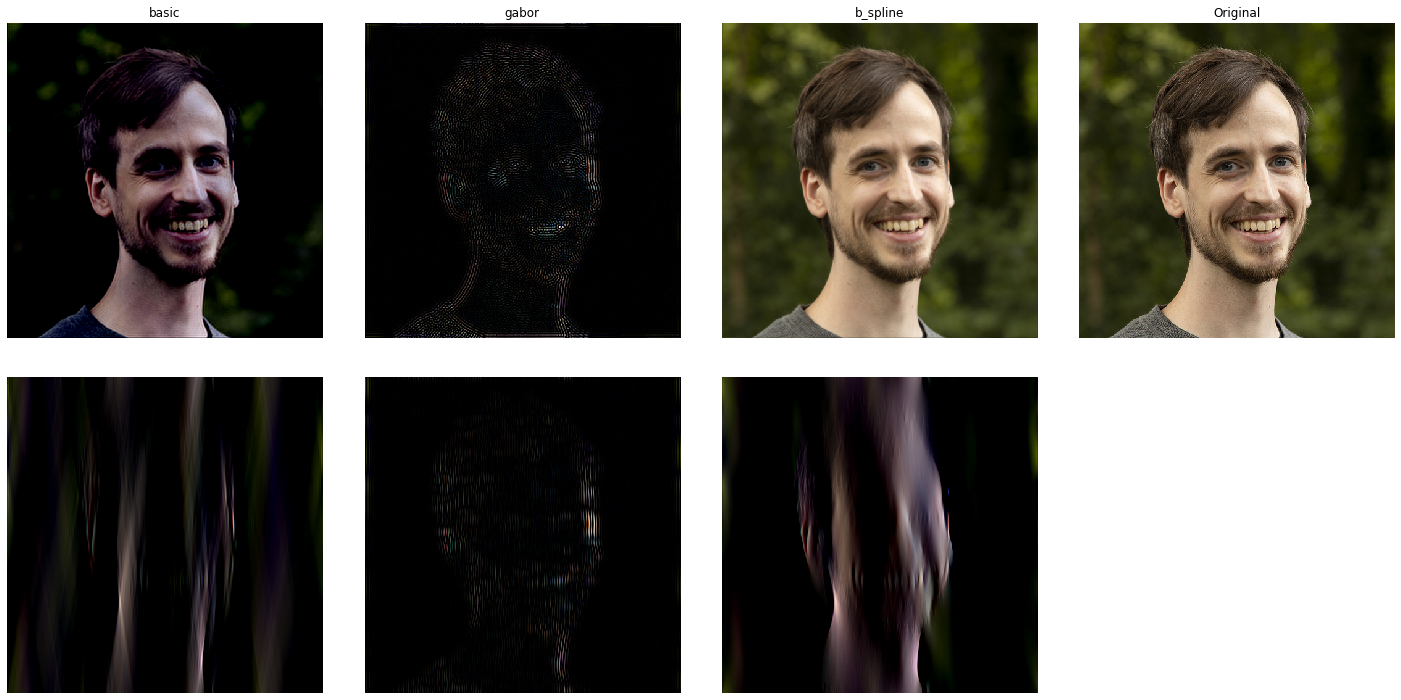

In [136]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
fig.tight_layout()
for i, layer in enumerate([basic_layer, gabor_layer, cake_layer]):
    x_ = layer(x)
    x_ = x_[0]
    recon = torch.real(x_.sum(1))
    recon /= recon.max()
    ax[0][i].imshow(recon.permute(1,2,0),vmax=1)
    ax[0][i].set_title(layer._wavelet_type)
    ax[0][i].axis('off')

    one_filter = torch.real(x_[:,0,:,:])
    ax[1][i].imshow((one_filter/one_filter.max()).permute(1,2,0))
    ax[1][i].axis('off')
ax[0][3].imshow(x[0].permute(1,2,0),vmax=1)
ax[0][3].set_title('Original')
ax[0][3].axis('off')

ax[1][3].imshow(torch.ones(x[0].shape).permute(1,2,0))
ax[1][3].axis('off')
plt.show()

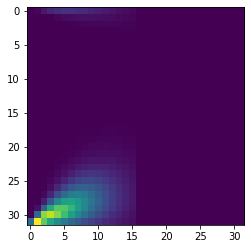

In [97]:
slices = 16
resolution = (32, 32)
filters = create_filter_bank(slices, resolution)
for f in filters[0,0]:
    plt.imshow(f)
plt.show()

tensor([[[0.5470, 0.6440, 0.6589,  ..., 0.2334, 0.2370, 0.3248],
         [0.6104, 0.7432, 0.7594,  ..., 0.1734, 0.1768, 0.2989],
         [0.6124, 0.7431, 0.7550,  ..., 0.1757, 0.1793, 0.3009],
         ...,
         [0.3343, 0.2936, 0.2899,  ..., 0.4677, 0.4683, 0.4295],
         [0.3307, 0.2894, 0.2881,  ..., 0.4628, 0.4653, 0.4285],
         [0.3895, 0.3868, 0.3902,  ..., 0.3970, 0.4012, 0.3980]],

        [[0.5828, 0.6880, 0.7005,  ..., 0.2530, 0.2565, 0.3484],
         [0.6511, 0.7966, 0.8113,  ..., 0.1885, 0.1919, 0.3203],
         [0.6532, 0.7931, 0.8091,  ..., 0.1909, 0.1944, 0.3232],
         ...,
         [0.3594, 0.3158, 0.3138,  ..., 0.5034, 0.5039, 0.4622],
         [0.3557, 0.3115, 0.3109,  ..., 0.4984, 0.5011, 0.4612],
         [0.4173, 0.4146, 0.4173,  ..., 0.4281, 0.4324, 0.4282]],

        [[0.1761, 0.2159, 0.2264,  ..., 0.0656, 0.0638, 0.0921],
         [0.1934, 0.2489, 0.2599,  ..., 0.0286, 0.0256, 0.0683],
         [0.1905, 0.2464, 0.2572,  ..., 0.0304, 0.0275, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


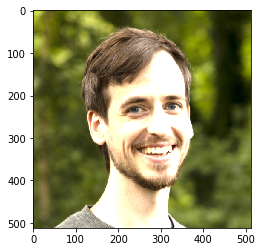

(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
1.0


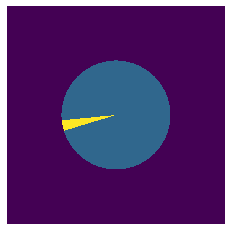

In [107]:
slices = 32
angle = 2*np.pi/slices
angles = np.linspace(0,2*np.pi, slices, endpoint=False)
filenames = []
c_type = 'basic'
images = []
cumulative = np.zeros((1024,1024))
for i, orientation in enumerate(angles):
    plt.clf()
    X, Y, val = bake_cake(orientation, angle, cake_type=c_type, resolution=(1024,1024))
    bx, by = calculate_boundaries(1, slices, radius_ticks=.5)
    images += [val]
    cumulative += val

    plt.imshow(cumulative+2*val, vmax=3, )
    # plt.imshow(val, vmax=1, cmap='gray')
    plt.axis('off')
    # plt.show()
    filenames+=['/Thesis/images/cake_'+str(i) +'.png']
    plt.savefig('/Thesis/images/cake_'+str(i) +'.png')
    # plt.show()
    
print(cumulative.max())
import imageio
with imageio.get_writer('./cake.gif', mode='I', duration=.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

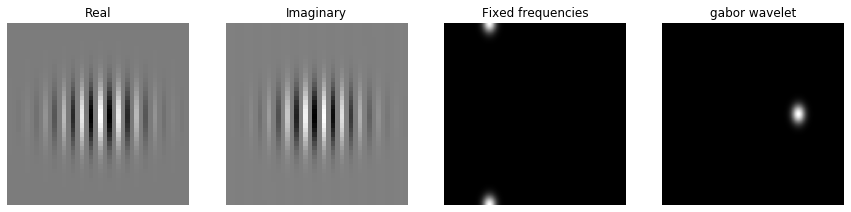

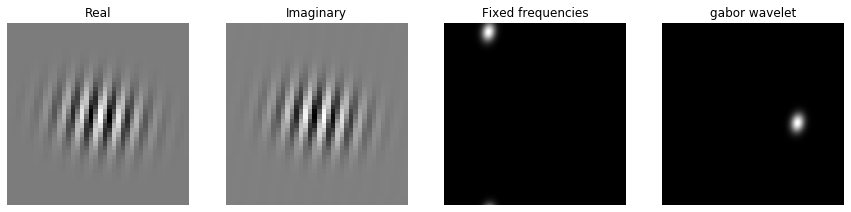

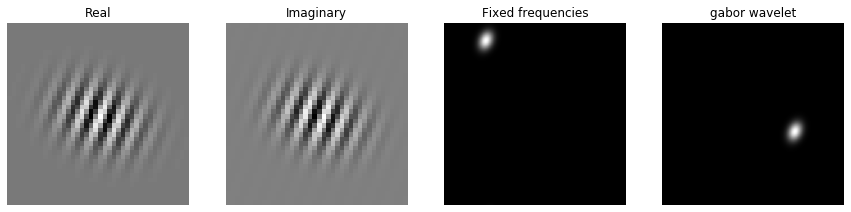

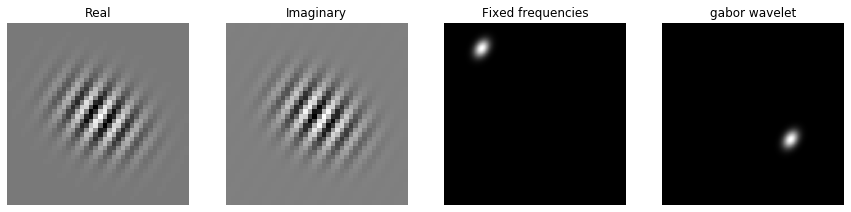

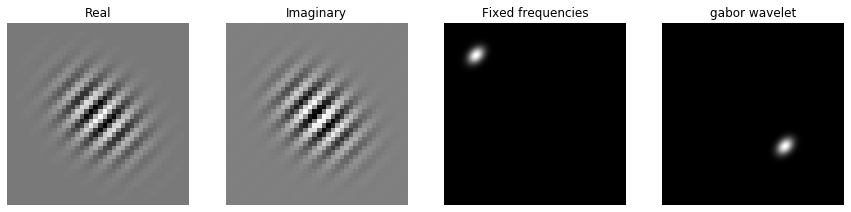

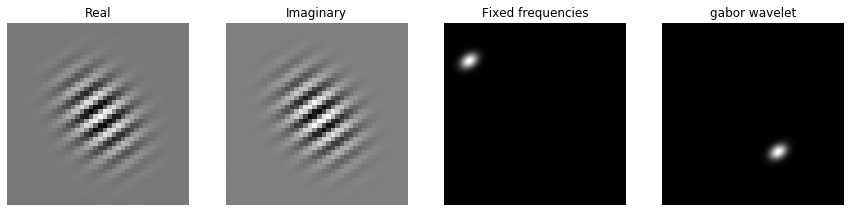

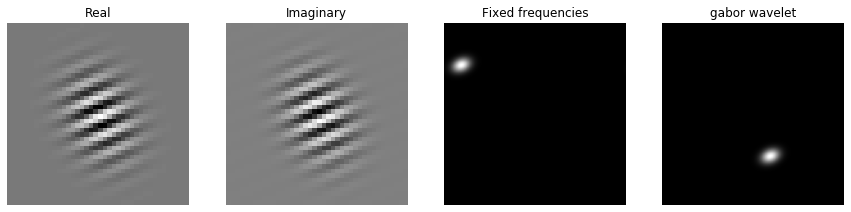

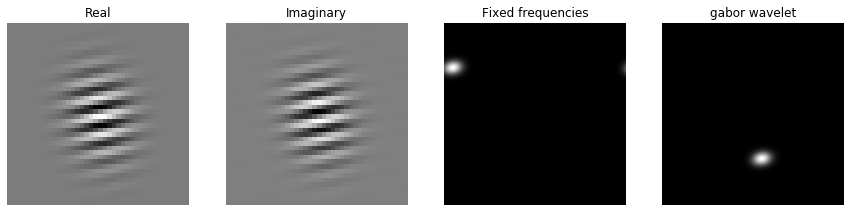

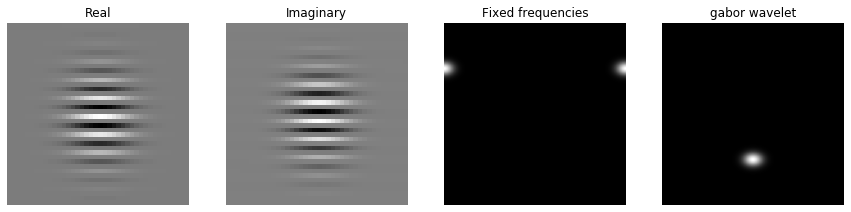

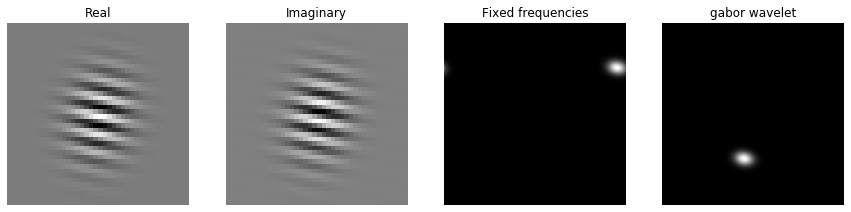

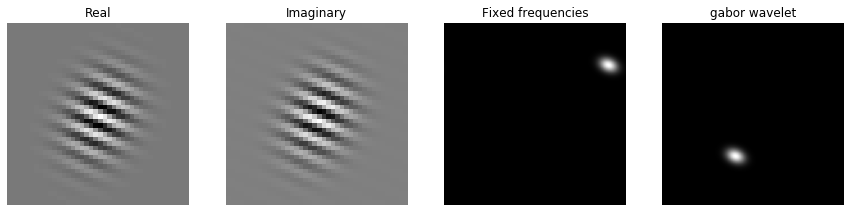

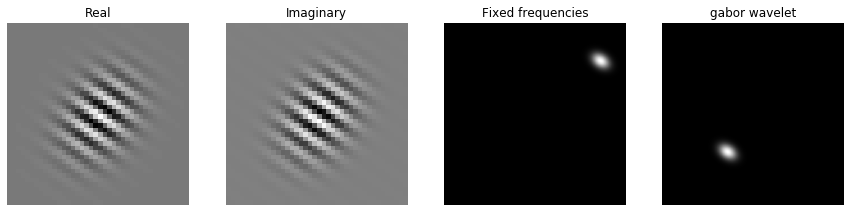

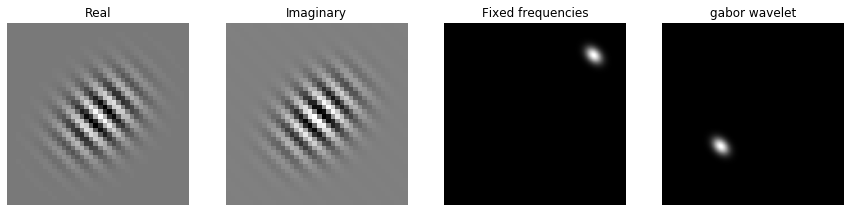

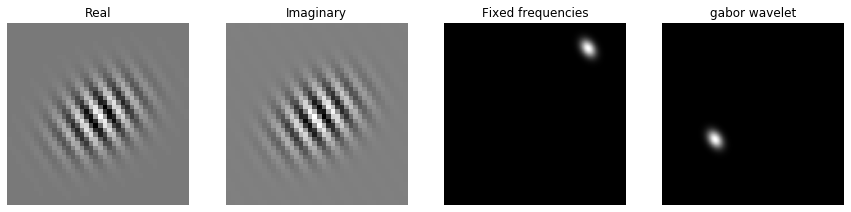

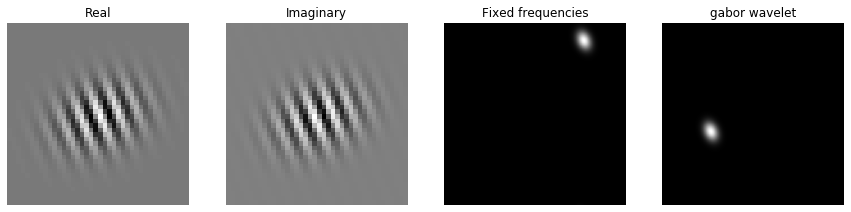

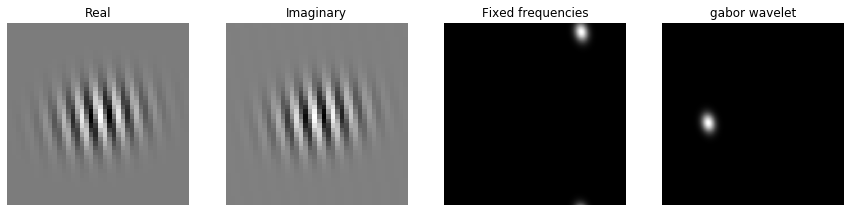

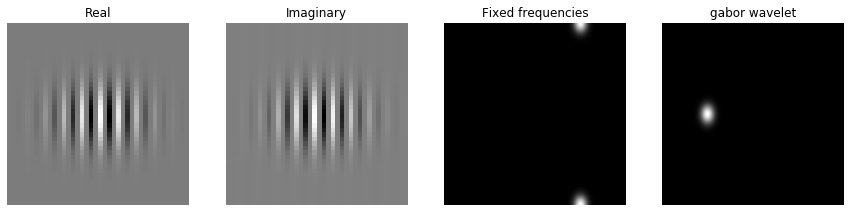

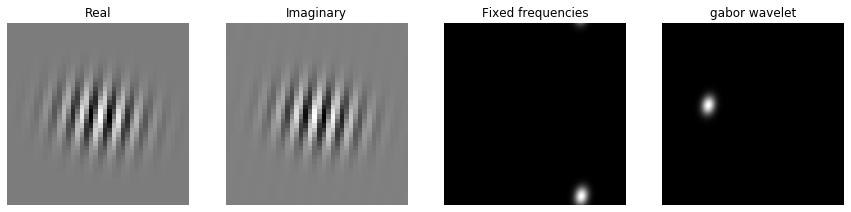

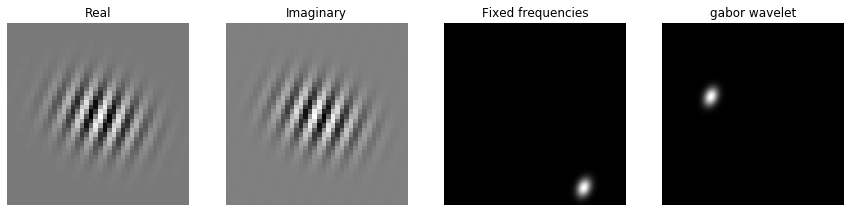

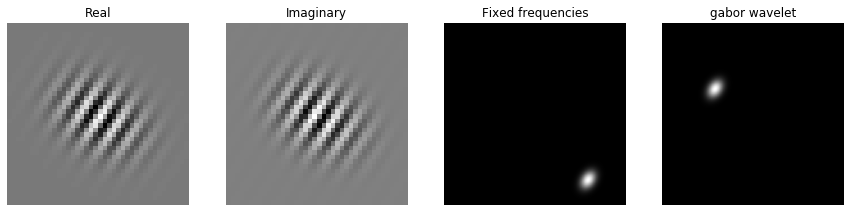

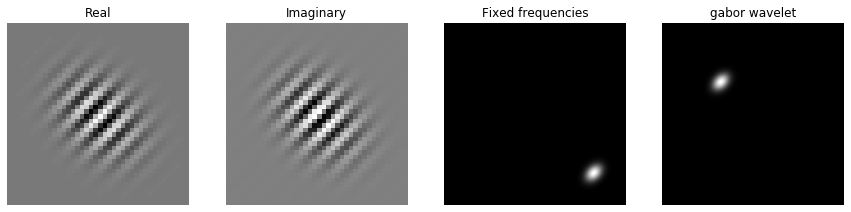

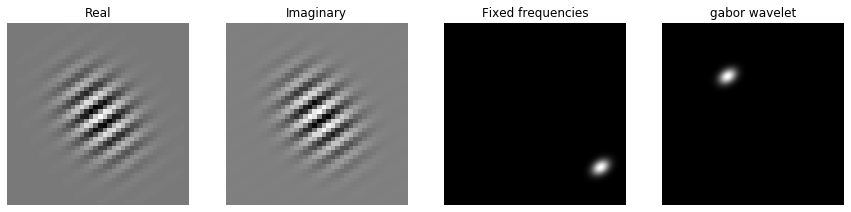

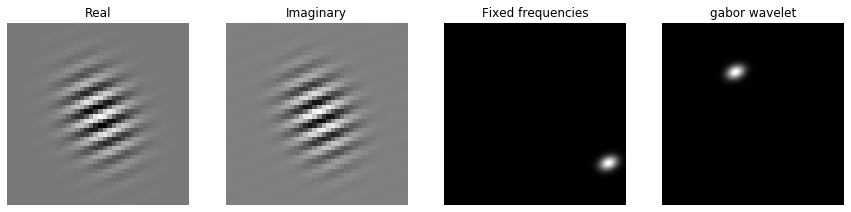

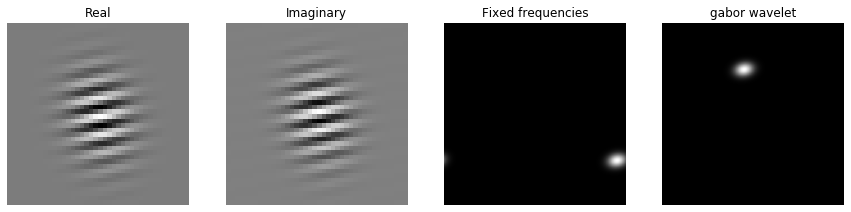

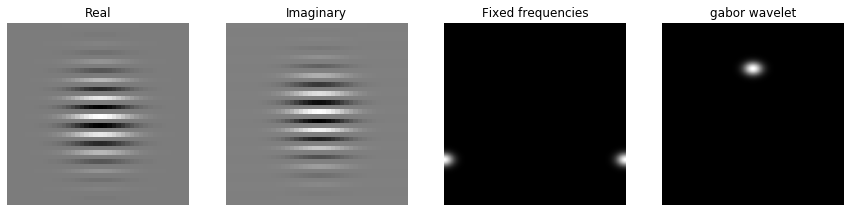

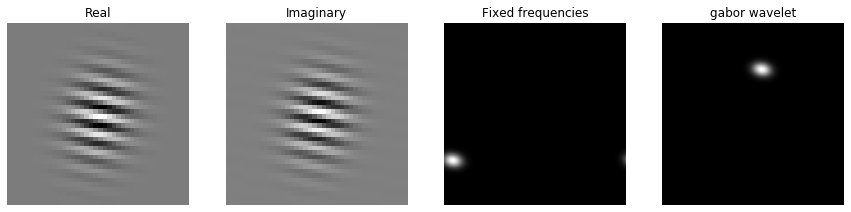

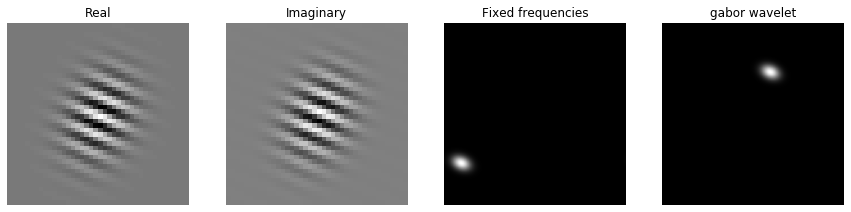

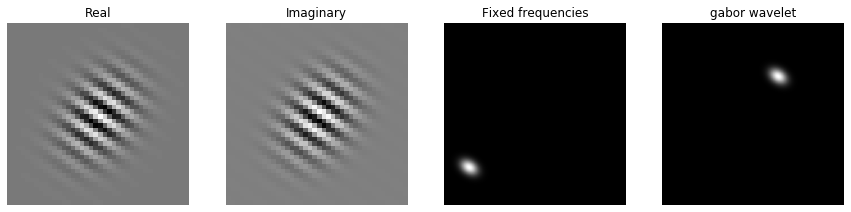

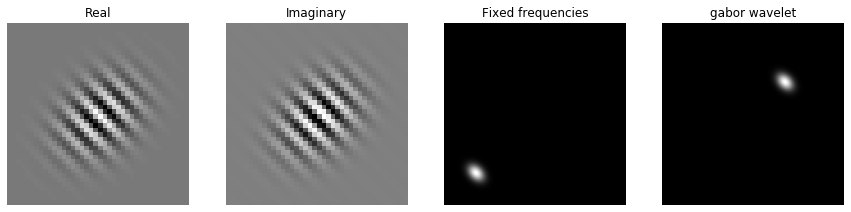

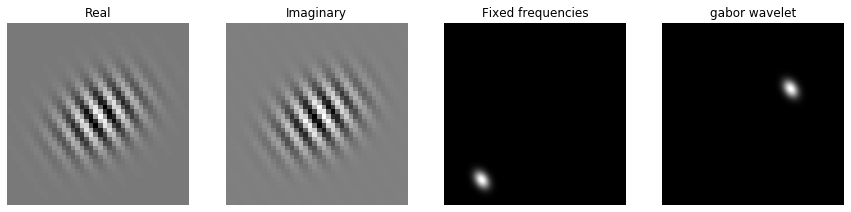

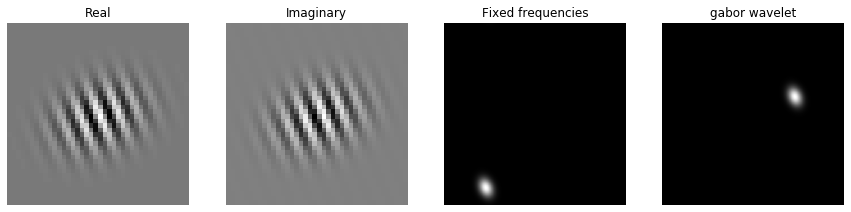

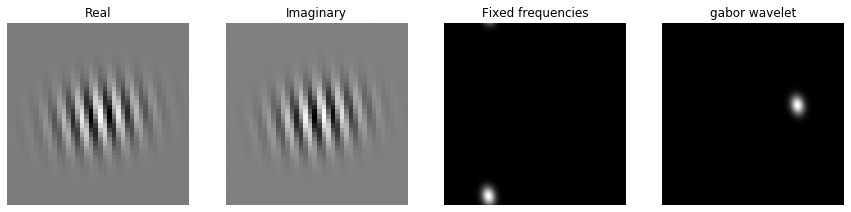

['/Thesis/images/ifft_0.png', '/Thesis/images/ifft_1.png', '/Thesis/images/ifft_2.png', '/Thesis/images/ifft_3.png', '/Thesis/images/ifft_4.png', '/Thesis/images/ifft_5.png', '/Thesis/images/ifft_6.png', '/Thesis/images/ifft_7.png', '/Thesis/images/ifft_8.png', '/Thesis/images/ifft_9.png', '/Thesis/images/ifft_10.png', '/Thesis/images/ifft_11.png', '/Thesis/images/ifft_12.png', '/Thesis/images/ifft_13.png', '/Thesis/images/ifft_14.png', '/Thesis/images/ifft_15.png', '/Thesis/images/ifft_16.png', '/Thesis/images/ifft_17.png', '/Thesis/images/ifft_18.png', '/Thesis/images/ifft_19.png', '/Thesis/images/ifft_20.png', '/Thesis/images/ifft_21.png', '/Thesis/images/ifft_22.png', '/Thesis/images/ifft_23.png', '/Thesis/images/ifft_24.png', '/Thesis/images/ifft_25.png', '/Thesis/images/ifft_26.png', '/Thesis/images/ifft_27.png', '/Thesis/images/ifft_28.png', '/Thesis/images/ifft_29.png', '/Thesis/images/ifft_30.png', '/Thesis/images/ifft_31.png']


In [46]:
import PIL.Image as Image
import torch

def create_gif(filenames, out_path):
    with imageio.get_writer(out_path, mode='I', duration=.5) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            
    
def transform_for_ifft(img):
    '''
        ifft expects positive frequencies 0:N followed by negative frequencies 0:N
    '''
    shape = img.shape
    N, M = shape
    img_2 = np.zeros(shape)
    pp_freqs = img[N//2:, M//2:]
    pn_freqs = img[N//2:, :M//2]
    np_freqs = img[:N//2, M//2:]
    nn_freqs = img[:N//2, :M//2]
    
    img_2 = np.zeros(shape)
    img_2[:N//2, :M//2] = pp_freqs
    img_2[:N//2, M//2:] = pn_freqs
    img_2[N//2:, :M//2] = np_freqs
    img_2[N//2:, M//2:] = nn_freqs
    return img_2

def recenter(img):
    shape = img.shape
    N, M = shape
    img_2 = np.zeros(shape, dtype=complex)
    img_2[N//2:,M//2:] = img[:N//2,:M//2]
    img_2[:N//2,M//2:] = img[N//2:,:M//2]
    img_2[N//2:,:M//2] = img[:N//2,M//2:]
    img_2[:N//2,:M//2] = img[N//2:,M//2:]
    return img_2

iffts = []
N,M = images[0].shape
for i,img in enumerate(images):
    # img = np.fft.ifft2(img+img*1j)
    
    img_2 = transform_for_ifft(img)
    ifft = np.fft.ifft2(img_2)
    ifft = recenter(ifft)
    
    fig,axs = plt.subplots(1,4, figsize=(15,15))
    for ax in axs:
        ax.axis('off')

    axs[0].set_title('Real')
    axs[0].imshow(np.real(ifft[N//2-20:N//2+20,M//2-20:M//2+20]), cmap='gray')

    axs[1].set_title('Imaginary')
    axs[1].imshow(np.imag(ifft[N//2-20:N//2+20,M//2-20:M//2+20]), cmap='gray')
    
    axs[2].set_title('Fixed frequencies')
    axs[2].imshow(img_2, cmap='gray')

    axs[3].set_title( c_type + ' wavelet' )
    axs[3].imshow(img, cmap='gray')
    


    iffts+=['/Thesis/images/ifft_'+str(i) +'.png']
    plt.savefig('/Thesis/images/ifft_'+str(i) +'.png')
    plt.show()
    
print(iffts)
create_gif(iffts, './iffts.gif')


In [143]:
ar = np.arange(10)
l = ar[1:5:-1]
print(l)

[]


In [ ]:
image